<a href="https://colab.research.google.com/github/ramajoballester/mil_deeplearning/blob/main/4_aplicaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sesión 4. Aplicaciones y casos de uso

## Detección con YOLOv5

In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision
import torchmetrics
from torch import nn
from torchsummary import summary

In [ ]:
# ! cd alvaro/data/
# ! git clone http://localhost:6002/?token=9fcb953d2b98a324e57d7182cbc6777bac995376d01b8e8f ./data/yolov5
! pip install -q -r alvaro/data/yolov5/requirements.txt

In [104]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
# model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)

Using cache found in /home/ansu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-6-22 Python-3.10.4 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3060, 12054MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [33]:
! wget -nc -P ./alvaro/data/ https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
! wget -nc -P ./alvaro/data/ https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
! unzip -q ./alvaro/data/Flickr8k_Dataset.zip -d ./alvaro/data/Flickr8k/
! unzip -q ./alvaro/data/Flickr8k_text.zip -d ./alvaro/data/Flickr8k/

File ‘./alvaro/data/Flickr8k_Dataset.zip’ already there; not retrieving.

File ‘./alvaro/data/Flickr8k_text.zip’ already there; not retrieving.



In [98]:
transf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((640, 640))
])
dataset = torchvision.datasets.Flickr30k(root='./alvaro/data/Flickr8k/Flicker8k_Dataset',
                                        ann_file='./alvaro/data/Flickr8k/Flickr8k.token.txt',
                                        transform=transf)

In [99]:
dataloader = torch.utils.data.DataLoader(dataset, 1, shuffle=True, num_workers=1)
data_iter = iter(dataloader)

In [100]:
x = next(data_iter)

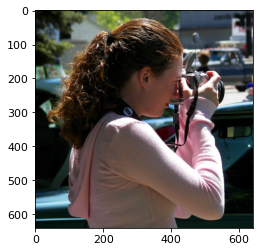

In [101]:
plt.imshow(x[0][0].permute(1, 2, 0))

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [103]:
names: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
        'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
x[0]

In [106]:
preds = model(x[0].to(device))

In [117]:
conf_threshold = 0.5
iou_threshold = 0.7

In [118]:
candidates = preds[..., 4] > conf_threshold  # candidates
final_preds = preds[candidates]

In [119]:
# Get bboxes
bboxes = final_preds[:, 0:4]
conf = final_preds[:, 4]
w = bboxes[:, 2]
h = bboxes[:, 3]
bboxes[:, 0] = bboxes[:, 0] - bboxes[:, 2]/2
bboxes[:, 1] = bboxes[:, 1] - bboxes[:, 3]/2
bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]

In [120]:
# Non-max suppression
selected_preds = torchvision.ops.nms(bboxes, conf, iou_threshold)
bboxes = bboxes[selected_preds]
conf = conf[selected_preds]
w = w[selected_preds]
h = h[selected_preds]

## Segmentación semántica

[UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation)